In [4]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import hshap
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# select device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# reproducibility
torch.set_grad_enabled(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# load pretrained model
model = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("model.pt", map_location=device))
model = model.to(device)
model.eval()
torch.cuda.empty_cache()

Using cache found in /home/xiangyu/.cache/torch/hub/pytorch_vision_v0.10.0
/home/xiangyu/.conda/envs/PyTc/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiangyu/.conda/envs/PyTc/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_344153/3136533773.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more 

In [6]:
# dataset transform
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
)

# load reference
ref = torch.load("reference.pt")
ref = ref.to(device)

# load annoations
annotations = pd.read_json("annotations.json")

# define annotation function
def annotate(ax, filename):
    query = annotations.loc[annotations["image"] == filename]
    for i, row in query.iterrows():
        trophozoites = row["objects"]
        for trophozoite in trophozoites:
            bbox = trophozoite["bounding_box"]
            upper_left_r = bbox["minimum"]["r"]
            upper_left_c = bbox["minimum"]["c"]
            lower_right_r = bbox["maximum"]["r"]
            lower_right_c = bbox["maximum"]["c"]
            w = np.abs(lower_right_c - upper_left_c)
            h = np.abs(lower_right_r - upper_left_r)
            rect = patches.Rectangle(
                (upper_left_c, upper_left_r),
                w,
                h,
                linewidth=2,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(rect)

/tmp/ipykernel_344153/3238418950.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ref = torch.load("reference.pt")


<>:45: SyntaxWarning: invalid escape sequence '\%'
<>:45: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_344153/2024695828.py:45: SyntaxWarning: invalid escape sequence '\%'
  % (threshold, "\%" if threshold_mode == "relative" else "", s)
  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_344153/2024695828.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  _abs = np.abs(explanation.flatten())


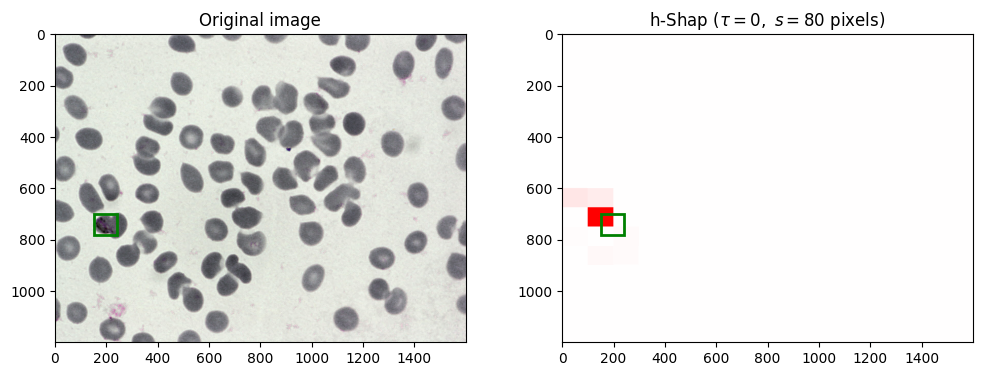

 20%|██        | 1/5 [00:12<00:48, 12.15s/it]/tmp/ipykernel_344153/2024695828.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  _abs = np.abs(explanation.flatten())


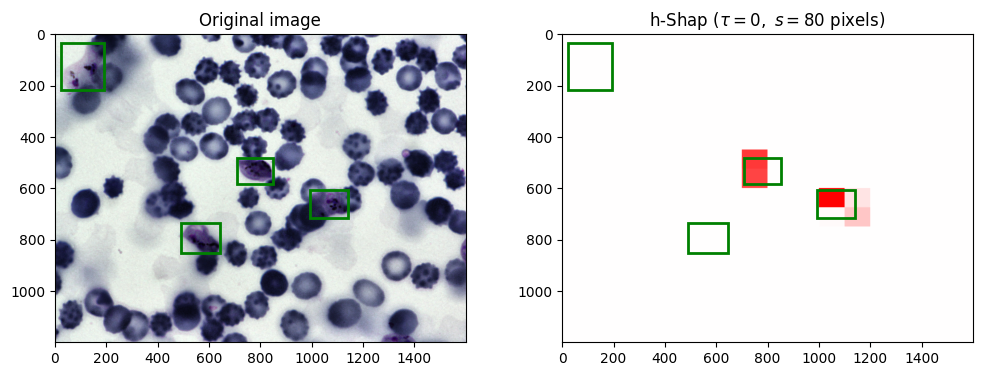

 40%|████      | 2/5 [00:23<00:35, 11.91s/it]/tmp/ipykernel_344153/2024695828.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  _abs = np.abs(explanation.flatten())


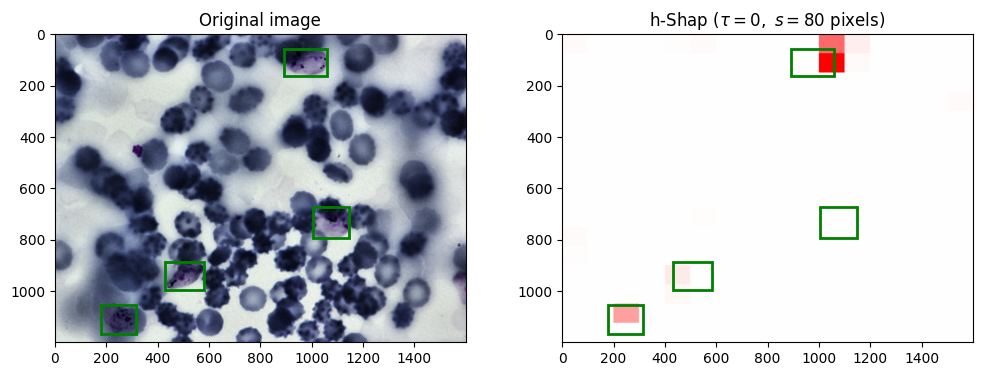

 60%|██████    | 3/5 [00:36<00:24, 12.44s/it]/tmp/ipykernel_344153/2024695828.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  _abs = np.abs(explanation.flatten())


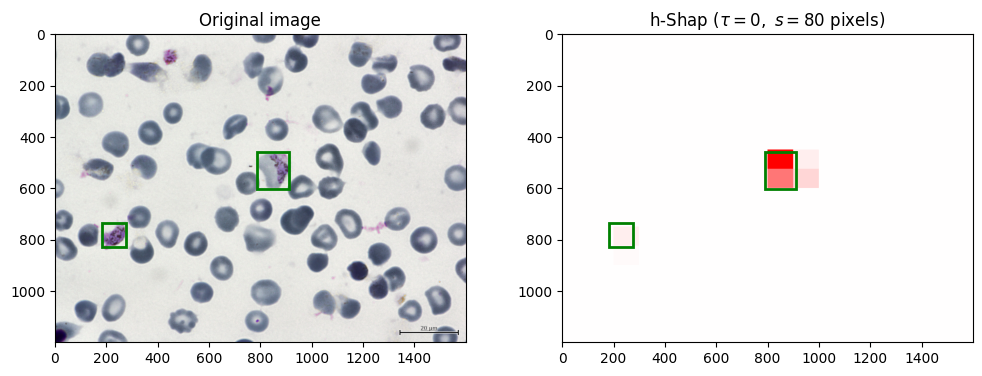

 80%|████████  | 4/5 [00:46<00:11, 11.21s/it]/tmp/ipykernel_344153/2024695828.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  _abs = np.abs(explanation.flatten())


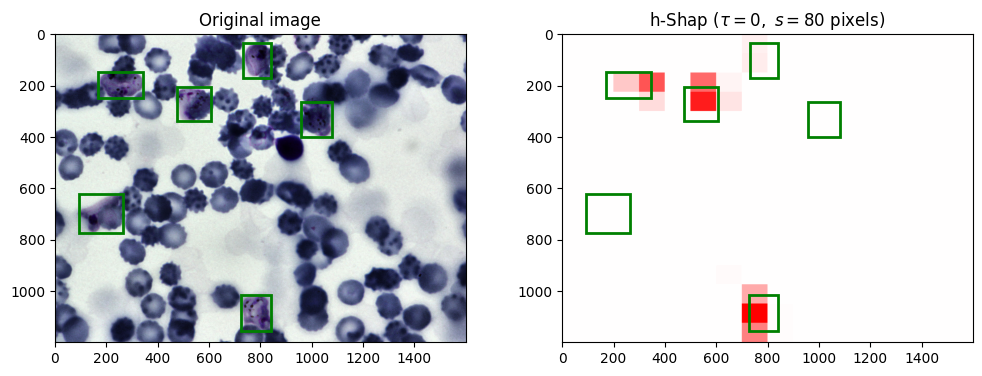

100%|██████████| 5/5 [00:58<00:00, 11.77s/it]


In [10]:
# initialize h-Shap explainer
s = 80
# hexp = hshap.Explainer(model, ref, min_size=s)
hexp = hshap.Explainer(model, ref)

# define thresholding modes
threshold_mode = "absolute"
threshold = 0
# for each example image
for (dirpath, _, filenames) in os.walk("images"):
    for filename in tqdm(filenames):
        # prepare figure
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # load and transform image
        image_path = os.path.join(dirpath, filename)
        image = Image.open(image_path)
        image_t = transform(image).to(device)

        # show original image
        ax = axes[0]
        ax.imshow(np.array(image))
        annotate(ax, filename)
        ax.set_title("Original image")

        # explain image
        explanation = hexp.explain(
            image_t,
            label=1,
            s=s,
            threshold_mode=threshold_mode,
            threshold=threshold,
            batch_size=1,
        )
        explanation.squeeze_()

        # show explanation
        ax = axes[1]
        _abs = np.abs(explanation.flatten())
        _max = max(_abs)
        ax.imshow(explanation, cmap="bwr", vmax=_max, vmin=-_max)
        annotate(ax, filename)
        ax.set_title(
            r"h-Shap ($\tau = %.0f%s,~s = %d$ pixels)"
            % (threshold, "\%" if threshold_mode == "relative" else "", s)
        )
        img_id = filename.split(".")[0]

        # save figure
        plt.savefig(os.path.join("explanations", f"{img_id}.jpg"))
        plt.show()
        plt.close()